**RAVDESS** dataset is used for this project. Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (*e.g., 02-01-06-01-02-01-12.mp4*). These identifiers define the stimulus characteristics:


---


```
*   Modality (01 = full-AV, 02 = video-only, 03 = audio-only)
*   Vocal channel (01 = speech, 02 = song)
*   Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
*   Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the ‘neutral’ emotion.
*   Statement (01 = “Kids are talking by the door”, 02 = “Dogs are sitting by the door”).
*   Repetition (01 = 1st repetition, 02 = 2nd repetition).
*   Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).
```





In [ ]:
!pip install librosa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import librosa
from librosa import display

In [ ]:
import soundfile
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from IPython.display import Audio
import joblib
from joblib import dump, load

In [ ]:
import os
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

# Plots for various emotions

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

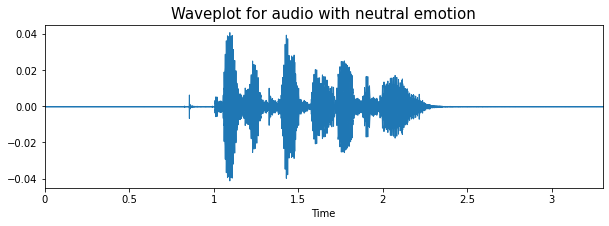

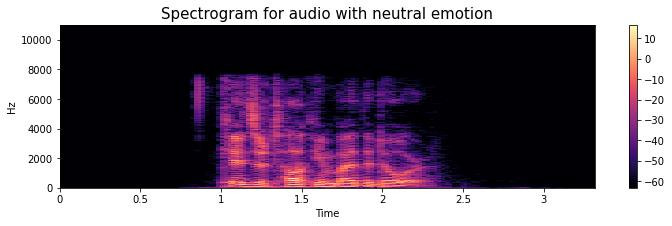

In [ ]:
emotion='neutral'
path = '/content/drive/MyDrive/RAVDESS/Actor_01/03-01-01-01-01-01-01.wav'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
data

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

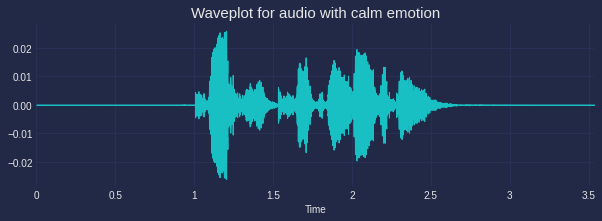

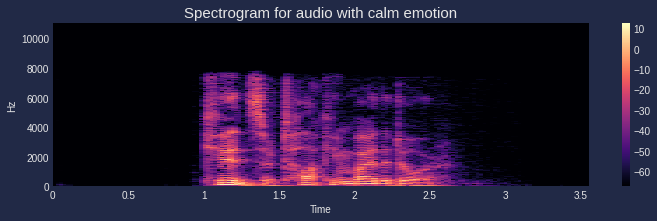

In [ ]:
emotion='calm'
path = '/content/drive/MyDrive/RAVDESS/Actor_01/03-01-02-01-01-01-01.wav'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

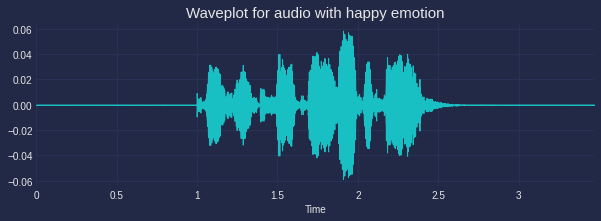

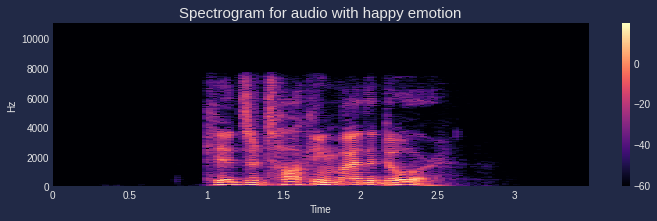

In [ ]:
emotion='happy'
path = '/content/drive/MyDrive/RAVDESS/Actor_01/03-01-03-01-01-01-01.wav'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

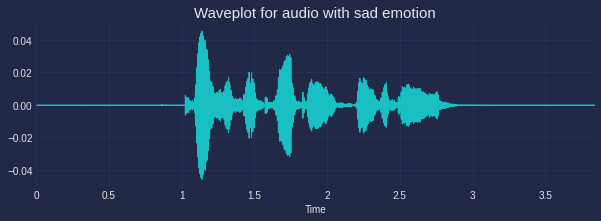

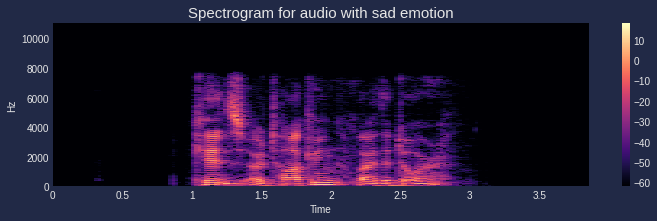

In [ ]:
emotion='sad'
path = '/content/drive/MyDrive/RAVDESS/Actor_01/03-01-04-01-01-01-01.wav'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

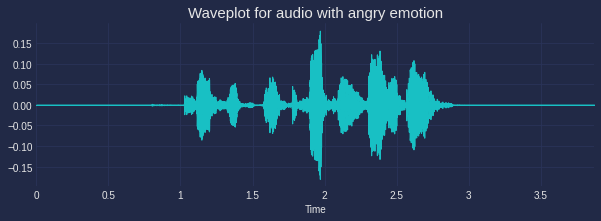

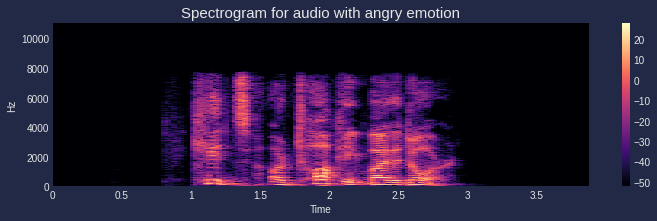

In [ ]:
emotion='angry'
path = '/content/drive/MyDrive/RAVDESS/Actor_01/03-01-05-01-01-01-01.wav'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

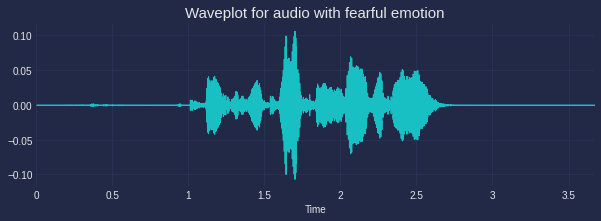

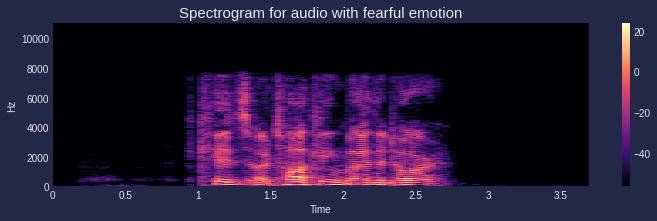

In [ ]:
emotion='fearful'
path = '/content/drive/MyDrive/RAVDESS/Actor_01/03-01-06-01-01-01-01.wav'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

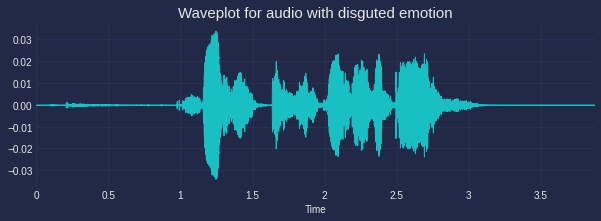

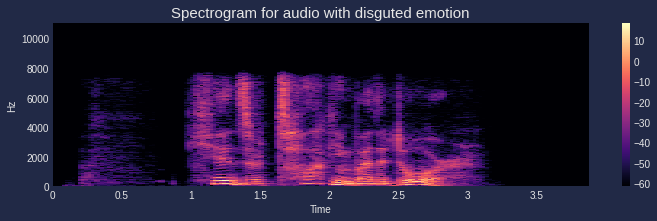

In [ ]:
emotion='disguted'
path = '/content/drive/MyDrive/RAVDESS/Actor_01/03-01-07-01-01-01-01.wav'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

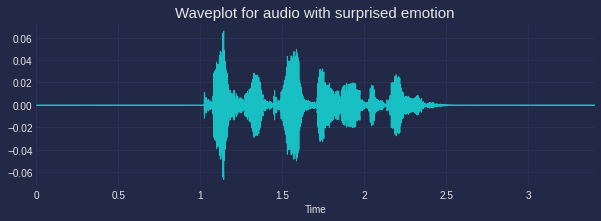

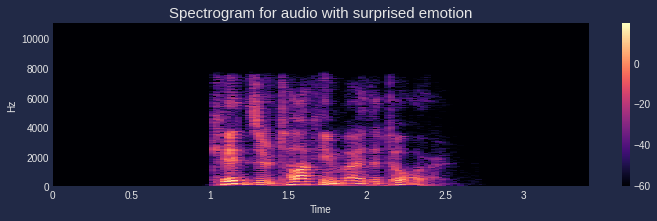

In [ ]:
emotion='surprised'
path = '/content/drive/MyDrive/RAVDESS/Actor_01/03-01-08-01-01-01-01.wav'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

The above plot describes the change in amplitude (loudness) of a signal over time domain. The next challenge is extracting the significant features from this wave form that can easily help to distinguish emotions embedded.


There are numerous ways to extract features from a raw audio waveform using signal processing such as zero crossing rate, spectral centroid, zooming in, and so on. After some experiments, I have decided to move forward with a combination of three main acoustic features which will be discussed below at a high level. In the case of audio waves, the variations in the amplitudes and frequencies contained in it can provide insights. A single audio wave consists of multiple single frequency signals. Extracting these individual, single frequency signals from the audio is called spectrum analysis.


Let’s think about what happens when we hear an audio clip with different kinds of  background noise. Human brains are a kind of spectrum analyzer which automatically split up the frequency signals in the audio and help us focus more on the main component, ignoring the single frequency signals of background noise. This same feature of splitting up the single frequencies in an audio file can be obtained by a mathematical technique called Fourier Transform. It basically transforms a time-domain signal into a frequency-domain signal. We now have information on how amplitude and frequency vary with time (separately, not together).


Our next task is to get the frequency and amplitude variations together with time. This is where the Spectogram comes in handy — it is a snapshot of the information of frequency, time, and amplitude in one. We will be using Mel-frequency cepstral coefficients (MFCCs). We will create a numpy array extracting Mel-frequency cepstral coefficients (MFCCs), while the classes to predict will be extracted from the name of the file.

# Feature extraction and loading

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [ ]:
path = '/content/drive/My Drive/RAVDESS'
lst = []

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        
        file = int(file[6:8])
        # data without augmentation
        result = extract_features(X)
        arr = result, file
        lst.append(arr)

        # data after augmentation
        # noise
        noised_data = noise(X)
        res2 = extract_features(noised_data)
        arr = res2, file
        lst.append(arr)

        # stretch and pitch
        stretched_data = stretch(X)
        data_stretch_pitch = pitch(stretched_data, sample_rate)
        res3 = extract_features(data_stretch_pitch)
        arr = res3, file
        lst.append(arr)
      
      # If the file is not valid, skip it
      except ValueError:
        continue

In [ ]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [ ]:
X = np.asarray(X)
y = np.asarray(y)
X.shape, y.shape

((4320, 162), (4320,))

**NOTE:**
```
Emotions = { "neutral": "01",
             "calm": "02",
             "happy": "03", 
             "sad": "04", 
             "angry": "05", 
             "fearful": "06", 
             "disgust": "07", 
             "surprised": "08" }
```

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3024, 162), (3024,), (1296, 162), (1296,))

In [ ]:
encoder = OneHotEncoder()
y_train_nn = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_test_nn = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

# Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
pred_dtree = dtree.predict(X_test)

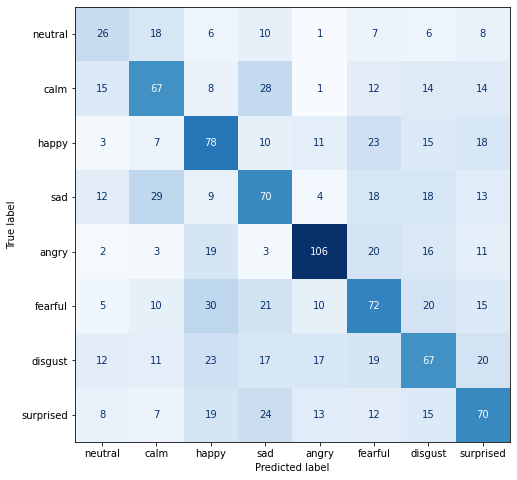

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_test,pred_dtree, cmap='Blues', ax=ax, display_labels=["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"], colorbar=False)

In [ ]:
acc_dtree = round(accuracy_score(y_test, pred_dtree)*100,2)
print(classification_report(y_test,pred_dtree))

              precision    recall  f1-score   support

           1       0.31      0.32      0.32        82
           2       0.44      0.42      0.43       159
           3       0.41      0.47      0.44       165
           4       0.38      0.40      0.39       173
           5       0.65      0.59      0.62       180
           6       0.39      0.39      0.39       183
           7       0.39      0.36      0.38       186
           8       0.41      0.42      0.42       168

    accuracy                           0.43      1296
   macro avg       0.42      0.42      0.42      1296
weighted avg       0.43      0.43      0.43      1296



In [ ]:
print('Test accuracy:',acc_dtree)

Test accuracy: 42.9


In [ ]:
# create an iterator object with write permission - model.pkl
with open('dtree_pkl', 'wb') as files:
    pickle.dump(dtree, files)

# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rforest = RandomForestClassifier(criterion="gini", max_depth=10, max_features="log2", 
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                 n_estimators= 22000, random_state= 5)

rforest.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features='log2', max_leaf_nodes=100,
                       min_samples_leaf=3, min_samples_split=20,
                       n_estimators=22000, random_state=5)

In [ ]:
pred_rforest = rforest.predict(X_test)

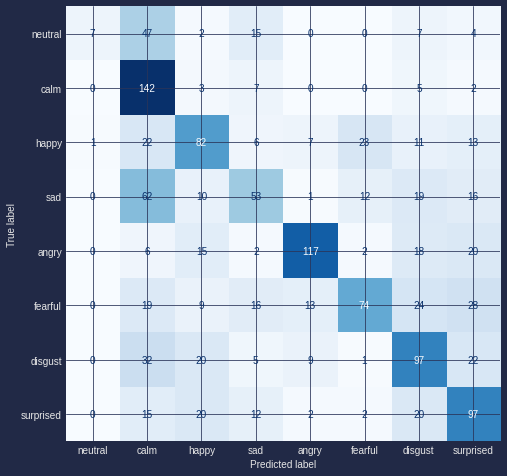

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_test,pred_rforest, cmap='Blues', ax=ax, display_labels=["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"], colorbar=False)

In [ ]:
acc_rforest = round(accuracy_score(y_test, pred_rforest)*100,2)
print(classification_report(y_test,pred_rforest))

              precision    recall  f1-score   support

           1       0.88      0.09      0.16        82
           2       0.41      0.89      0.56       159
           3       0.51      0.50      0.50       165
           4       0.46      0.31      0.37       173
           5       0.79      0.65      0.71       180
           6       0.65      0.40      0.50       183
           7       0.48      0.52      0.50       186
           8       0.48      0.58      0.52       168

    accuracy                           0.52      1296
   macro avg       0.58      0.49      0.48      1296
weighted avg       0.56      0.52      0.50      1296



In [ ]:
print('Test accuracy:',acc_rforest)

Test accuracy: 51.62


In [ ]:
# create an iterator object with write permission - model.pkl
with open('rforest_pkl', 'wb') as files:
    pickle.dump(rforest, files)

# Neural Network

In [ ]:
!pip install keras.utils 

  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2656 sha256=8d7dff308382562593bcf29b3cd0ad7a7be57f0bfe11e37f0a4f3b1053c72cc3
  Stored in directory: /root/.cache/pip/wheels/d0/dd/3b/493952a5240d486a83805d65360dedadbadeae71d25e2c877f
Successfully built keras.utils


In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [ ]:
# importing necessary libraries for neural network
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(X_train, axis=2)
x_test = np.expand_dims(X_test, axis=2)
x_train.shape, y_train_nn.shape, x_test.shape, y_test_nn.shape

((3024, 162, 1), (3024, 8), (1296, 162, 1), (1296, 8))

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history = model.fit(x_train, y_train_nn, batch_size=64, epochs=50, validation_data=(x_test, y_test_nn), callbacks=[rlrp])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/50
48/48 [==============================] - 45s 936ms/step - loss: 2.0150 - accuracy: 0.1806 - val_loss: 1.9428 - val_accuracy: 0.1998 - lr: 0.0010
Epoch 2/50
48/48 [==============================] - 29s 603ms/step - loss: 1.9408 - accuracy: 0.2275 - val_loss: 1.8691 - val_accuracy: 0.2631 - lr: 0.0010
Epoch 3/50
48/48 [==============================] - 25s 525ms/step - loss: 1.9161 - accuracy: 0.2345 - val_loss: 1.8607 - val_accuracy: 0.2523 - lr: 0.0010
Epoch 4/50
48/48 [==============================] - 25s 529ms/step - loss: 1.8661 - accuracy: 0.2622 - val_loss: 1.8104 - val_accuracy: 0.2971 - lr: 0.0010
Epoch 5/50
48/48 [==============================] - 26s 545ms/step - loss: 1.8230 - accuracy: 0.2910 - val_loss: 1.7522 - val_accuracy: 0.3133 - lr: 0.0010
Epoch 6/50
48/48 [==============================] - 26s 535ms/step - loss: 1.7803 - accuracy: 0.3039 - val_loss: 1.7037 - val_accuracy: 0.3341 - lr: 0.0010
Epoch 7/50
48/48 [==============================] - 25s 530ms/st

 1/41 [..............................] - ETA: 3s - loss: 0.9167 - accuracy: 0.5625

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


41/41 [==============================] - 3s 80ms/step - loss: 1.3811 - accuracy: 0.6073
Accuracy of our model on test data :  60.72530746459961 %


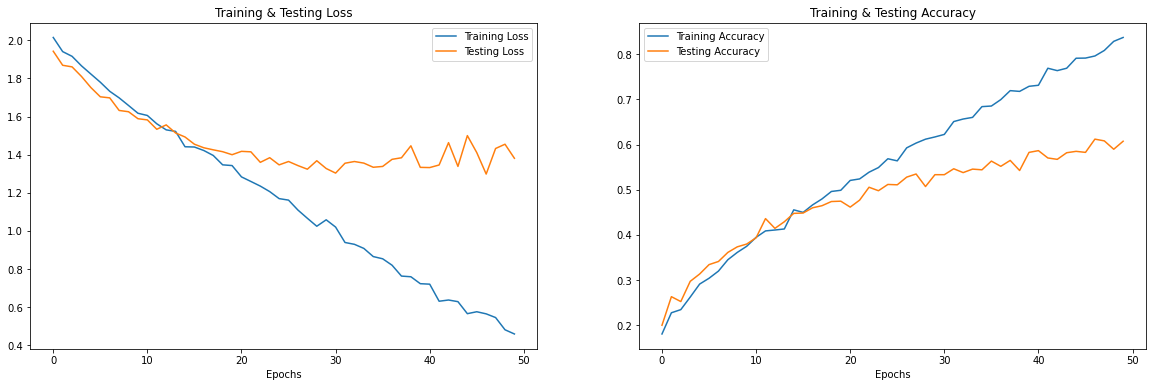

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test_nn)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
pred_nn_ = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test_nn)

In [ ]:
pred_nn = [i for l in pred_nn_ for i in l]
y_test = [i for l in y_test for i in l]

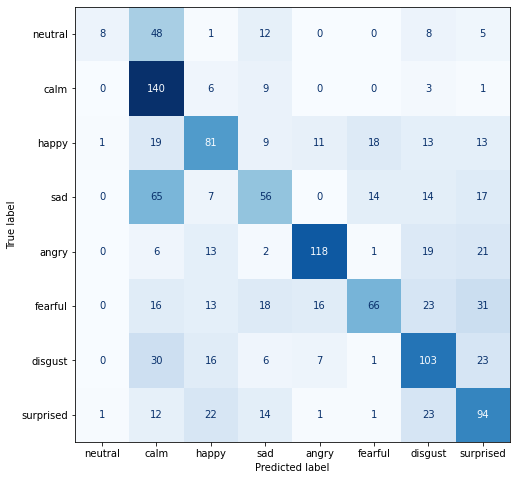

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_test, pred_nn, cmap='Blues', ax=ax, display_labels=["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"], colorbar=False)

In [ ]:
acc_nn = round(accuracy_score(y_test, pred_nn)*100,2)
print(classification_report(y_test,pred_nn))

              precision    recall  f1-score   support

           1       0.47      0.46      0.47        82
           2       0.67      0.81      0.73       159
           3       0.56      0.47      0.51       165
           4       0.60      0.49      0.54       173
           5       0.68      0.71      0.69       180
           6       0.71      0.50      0.59       183
           7       0.53      0.66      0.59       186
           8       0.59      0.70      0.64       168

    accuracy                           0.61      1296
   macro avg       0.60      0.60      0.59      1296
weighted avg       0.61      0.61      0.60      1296



In [ ]:
print('Test accuracy:',acc_nn)

Test accuracy: 60.73


# MLP Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [ ]:
mlp.fit(X_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [ ]:
pred_mlp = mlp.predict(X_test)

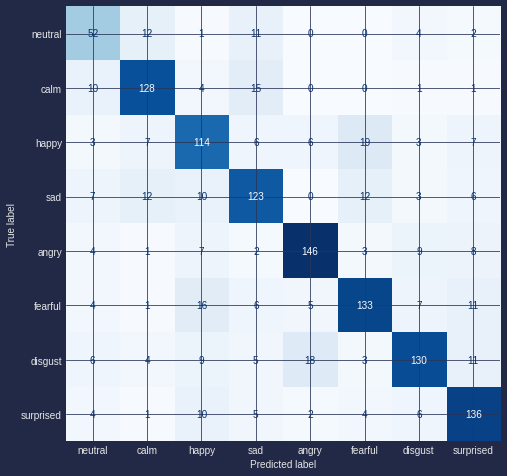

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_test,pred_mlp, cmap='Blues', ax=ax, display_labels=["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"], colorbar=False)

In [ ]:
acc_mlp = round(accuracy_score(y_test, pred_mlp)*100,2)
print(classification_report(y_test,pred_mlp))

              precision    recall  f1-score   support

           1       0.58      0.63      0.60        82
           2       0.77      0.81      0.79       159
           3       0.67      0.69      0.68       165
           4       0.71      0.71      0.71       173
           5       0.82      0.81      0.82       180
           6       0.76      0.73      0.75       183
           7       0.80      0.70      0.74       186
           8       0.75      0.81      0.78       168

    accuracy                           0.74      1296
   macro avg       0.73      0.74      0.73      1296
weighted avg       0.74      0.74      0.74      1296



In [ ]:
print('Test accuracy:',acc_mlp)

Test accuracy: 74.23


In [ ]:
# create an iterator object with write permission - model.pkl
with open('mlp_pkl', 'wb') as files:
    pickle.dump(mlp, files)

# Light GBM

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
lgbm = LGBMClassifier(learning_rate=0.05,
                      n_estimators=10000,
                      max_depth=5)

In [ ]:
lgbm.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.05, max_depth=5, n_estimators=10000)

In [ ]:
pred_lgbm = lgbm.predict(X_test)

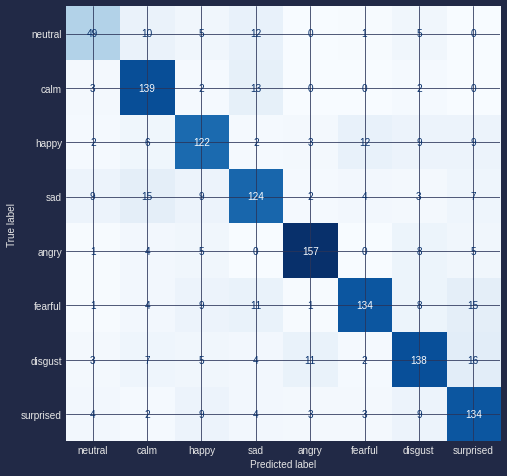

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(y_test,pred_lgbm, cmap='Blues', ax=ax, display_labels=["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"], colorbar=False)

In [ ]:
acc_lgbm = round(accuracy_score(y_test, pred_lgbm)*100,2)
print(classification_report(y_test,pred_lgbm))

              precision    recall  f1-score   support

           1       0.68      0.60      0.64        82
           2       0.74      0.87      0.80       159
           3       0.73      0.74      0.74       165
           4       0.73      0.72      0.72       173
           5       0.89      0.87      0.88       180
           6       0.86      0.73      0.79       183
           7       0.76      0.74      0.75       186
           8       0.72      0.80      0.76       168

    accuracy                           0.77      1296
   macro avg       0.76      0.76      0.76      1296
weighted avg       0.77      0.77      0.77      1296



In [ ]:
print('Test accuracy:',acc_lgbm)

Test accuracy: 76.93


In [ ]:
lgbm.booster_.save_model('lgbm.txt')

In [ ]:
import lightgbm

In [ ]:
mo = lightgbm.Booster(model_file='lgbm.txt')

In [ ]:
# create an iterator object with write permission - model.pkl
with open('lgbm_pkl', 'wb') as files:
    pickle.dump(lgbm, files)

# Pipeline



```
Pipeline = Scaling -> Model Training
```



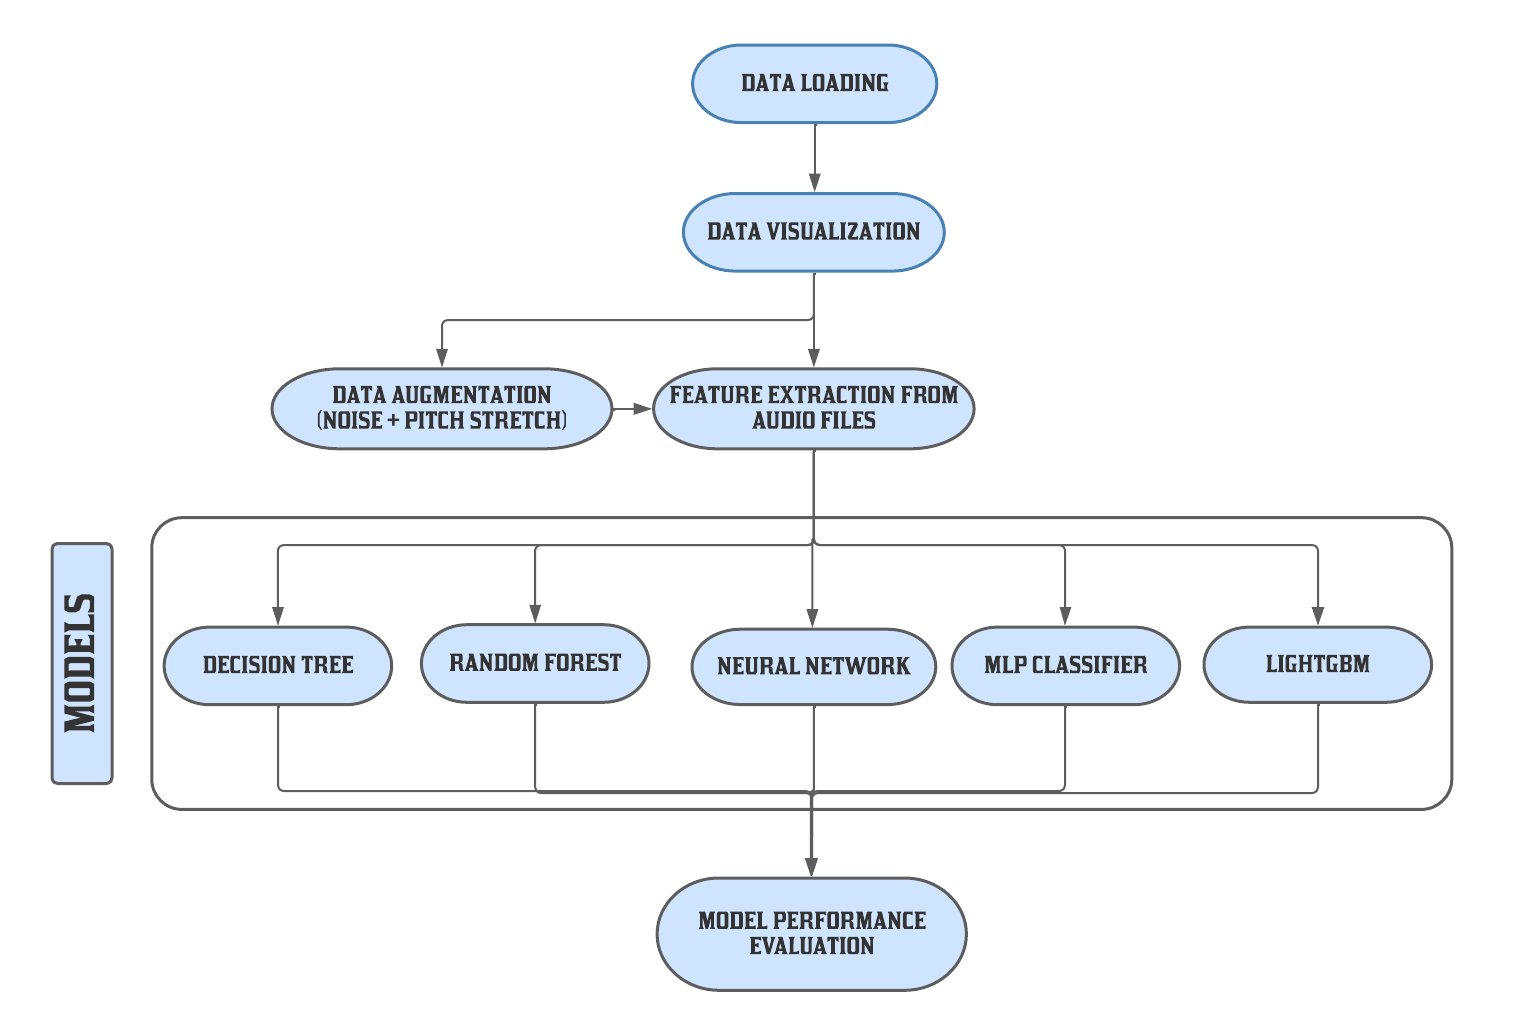

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
pipeline_dtree = Pipeline([('scalar1',StandardScaler()),
                           ('dtree_classifier',DecisionTreeClassifier())])

pipeline_rforest = Pipeline([('scalar2',StandardScaler()),
                           ('rforest_classifier',RandomForestClassifier(criterion="gini", max_depth=10, max_features="log2", 
                                                                        max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                                                        n_estimators= 22000, random_state= 5))])

pipeline_mlp = Pipeline([('scalar4',StandardScaler()),
                           ('mlp_classifier',MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, 
                                                           hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500))])

pipeline_lgbm = Pipeline([('scalar5',StandardScaler()),
                           ('lgbm_classifier',LGBMClassifier(learning_rate=0.05,
                                                              n_estimators=10000,
                                                              max_depth=5))])

In [ ]:
# list of all model pipelines
pipelines = [pipeline_dtree, pipeline_rforest, pipeline_mlp, pipeline_lgbm]

In [ ]:
best_accuracy = 0.0
best_classifier = 0
best_pipeline = ""

In [ ]:
# dictionary of pipelines
pipe_dict = {0:"Decision Tree", 
             1:"Random Forest", 
             2:"Multi-layered Perceptron", 
             3:"Light GBM",}

In [ ]:
# fiting the pipelines
for pipe in pipelines:
  pipe.fit(X_train,y_train)

In [ ]:
results = pd.DataFrame(data=None, columns=['Model','Accuracy'])

In [ ]:
# evaluating the models
for i,model in enumerate(pipelines):
  acc = round(model.score(X_test,y_test)*100,2)
  results.loc[len(results.index)] = [pipe_dict[i] ,acc]
  if acc > best_accuracy:
    best_accuracy = acc
    best_pipeline = model
    best_classifier = i

In [ ]:
print('{} Classifier gives the best accuracy: {}%'.format(pipe_dict[best_classifier],best_accuracy))

Light GBM Classifier gives the best accuracy: 77.0%


In [ ]:
results.loc[len(results.index)] = ['CNN Classifier' ,acc_nn]

In [ ]:
results.sort_values(by=['Accuracy'])

,Model,Accuracy
0,Decision Tree,44.52
1,Random Forest,51.39
4,CNN Classifier,60.73
2,Multi-layered Perceptron,74.07
3,Light GBM,76.62
